## Plotting Place cells in VR 




In [7]:
%reload_ext autoreload
%autoreload 2

from neuro_py.behavior.linear_positions import get_linear_track_lap_epochs
from skimage import measure
from neuro_py.tuning import maps
from neuro_py.plotting.figure_helpers import set_size
from neuro_py.io import loading
import pandas as pdl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl


tex_fonts = {
    #     # Use LaTeX to write all text
    "font.family": "arial",
    # Use 10pt font in plots
    "axes.labelsize": 8,
    "font.size": 8,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": "none",
}
plt.style.use("seaborn-paper")
plt.rcParams.update(tex_fonts)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
def restrict_to_place_cells(
    tc,
    st_run,
    bst_run,
    st_all,
    cell_metrics,
    place_cell_min_spks,
    place_cell_min_rate,
    place_cell_peak_mean_ratio,
):
    # locate pyr cells with >= 100 spikes, peak rate >= 1 Hz, peak/mean ratio >=1.5
    peak_firing_rates = tc.max(axis=1)
    mean_firing_rates = tc.mean(axis=1)
    ratio = peak_firing_rates / mean_firing_rates

    idx = (
        (st_run.n_events >= place_cell_min_spks)
        & (tc.ratemap.max(axis=1) >= place_cell_min_rate)
        & (ratio >= place_cell_peak_mean_ratio)
    )
    unit_ids_to_keep = (np.where(idx)[0] + 1).squeeze().tolist()

    sta_placecells = st_all._unit_subset(unit_ids_to_keep)
    tc = tc._unit_subset(unit_ids_to_keep)
    total_units = sta_placecells.n_active
    bst_run = bst_run.loc[:, unit_ids_to_keep]

    # restrict cell_metrics to place cells
    cell_metrics_ = cell_metrics[idx]

    return sta_placecells, tc, bst_run, cell_metrics_, total_units

import copy 

def make_snake(X):
    return np.argsort(np.argmax(X, axis=1))


### Get linear track basepaths

In [9]:

sessions = [r'Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day08_230413_095156',
    r'Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day09_230414_154029',
    r'Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day10_230417_133959',
    r'Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day11_230420_114016',
    r'Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day12_230421_133630',
    r'Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day14_230425_121247',
    r'Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day13_230424_104512',
    r'Y:\laura_berkowitz\VR_ephys\data\VR05\VR05_day13_230424_104512',
    r'Y:\laura_berkowitz\VR_ephys\data\VR05\VR05_day18_230501_091912']

# create session dataframe
sessions = pd.DataFrame(sessions,columns = ['basepath'])
sessions

NameError: name 'pd' is not defined

### 2. load in behavior and spike data

In [ ]:
# for each basepath in sessions, determine the number of place cells and the number of units
    

In [ ]:
# bach process all sessions
from ripple_heterogeneity.utils import batch_analysis
from src.place_cells import vr_place_cells

save_path = (
    r'Y:\laura_berkowitz\VR_ephys\analysis\place_cells_v1'
    )

batch_analysis.run(
    sessions,
    save_path,
    vr_place_cells.main,
    parallel=False,
    verbose=False,
    overwrite=False,
)



100%|██████████| 9/9 [00:00<00:00, 231.97it/s]


In [ ]:
from src.place_cells import vr_place_cells

save_path = (
    r'Y:\laura_berkowitz\VR_ephys\analysis\place_cells_v1'
    )

label_df, tuning = vr_place_cells.load_results(save_path)
label_df['constant'] = 1
label_df['shuff_pass'] = (label_df.pvals < 0.05) & (np.nanmax(tuning,axis=0) > 1)

loading Y:\laura_berkowitz\VR_ephys\analysis\place_cells_v1\Y---___laura_berkowitz___VR_ephys___data___VR04___VR04_day08_230413_095156.pkl
loading Y:\laura_berkowitz\VR_ephys\analysis\place_cells_v1\Y---___laura_berkowitz___VR_ephys___data___VR04___VR04_day09_230414_154029.pkl
loading Y:\laura_berkowitz\VR_ephys\analysis\place_cells_v1\Y---___laura_berkowitz___VR_ephys___data___VR04___VR04_day10_230417_133959.pkl
loading Y:\laura_berkowitz\VR_ephys\analysis\place_cells_v1\Y---___laura_berkowitz___VR_ephys___data___VR04___VR04_day11_230420_114016.pkl
loading Y:\laura_berkowitz\VR_ephys\analysis\place_cells_v1\Y---___laura_berkowitz___VR_ephys___data___VR04___VR04_day12_230421_133630.pkl
loading Y:\laura_berkowitz\VR_ephys\analysis\place_cells_v1\Y---___laura_berkowitz___VR_ephys___data___VR04___VR04_day13_230424_104512.pkl
loading Y:\laura_berkowitz\VR_ephys\analysis\place_cells_v1\Y---___laura_berkowitz___VR_ephys___data___VR04___VR04_day14_230425_121247.pkl
loading Y:\laura_berkowitz\

In [ ]:
place_idx =  label_df.loc[(label_df.pvals < 0.05) & (np.nanmax(tuning,axis=0) > 1)].index
tuning = tuning.loc[:,place_idx]
tuning_zscore = (tuning - np.nanmean(tuning,axis=0)) / np.nanstd(tuning,axis=0)

# keep cells that met shuffle
tuning_zscore = tuning_zscore.loc[:,label_df.pvals < 0.05]
# keep cells with min peak rate of 1 Hz
tuning_zscore = tuning_zscore.loc[:,np.nanmax(tuning_zscore,axis=0) > 1]
# reset column index
tuning_zscore.columns = np.arange(tuning_zscore.shape[1])

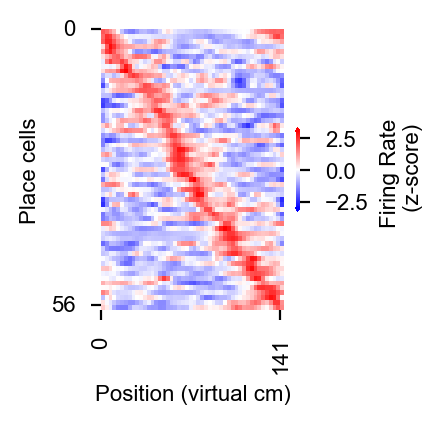

In [ ]:

idx = make_snake(tuning_zscore.values.T)

plt.figure(figsize = set_size('thesis', fraction=.25, subplots=(2, 1)))
#plot heatmap and make colorbar smaller to fit

ax = sns.heatmap(tuning_zscore.loc[:,idx].T,vmax=3,vmin=-3,cmap='bwr',cbar_kws={'label': 'Firing Rate \n (z-score)','shrink': 0.3,'extend':'both'})

plt.ylabel('Place cells')
# relabel ytick labels as 0 to n rows
plt.yticks(np.arange(0,tuning_zscore.shape[1],tuning_zscore.shape[1]-1),np.arange(0,tuning_zscore.shape[1],tuning_zscore.shape[1]-1))
# round xticklabels to 2 decimal places
plt.xticks(np.arange(0,tuning_zscore.shape[0],47),[0,141])
plt.xlabel('Position (virtual cm)')

plt.savefig(r'Y:\laura_berkowitz\VR_ephys\figures\place_cell_snake.svg',dpi=300,bbox_inches='tight')


In [ ]:
# for each basepath in label_df, create spike on position plot for each cell with pval < 0.05 and peak rate > 1 Hz

place_idx =  label_df.loc[label_df.shuff_pass == 1].index
place_df = label_df.loc[place_idx]

for basepath in place_df.basepath.unique():
   # get UID for place cells in this session
   place_uid = place_df.loc[place_df.basepath == basepath].UID.values
   # remove nan
   place_uid = place_uid[~np.isnan(place_uid)]

   if len(place_uid) == 0:
      continue
   # load data 
   pos, st, cm, beh_epochs, epoch_df = vr_place_cells.load_data(basepath)

   # find behavior_idx from epoch_df
   behavior_idx = int(epoch_df[epoch_df["name"].str.contains("vr")].index[0])

   # get pos and st for behavior epoch
   pos = pos[beh_epochs[behavior_idx]]
   st = st[beh_epochs[behavior_idx]]

   



c:\users\schafferlab\github\appps1_ripples\src\place_cells\vr_place_cells.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### boxplot for mean firing rate of place cells 

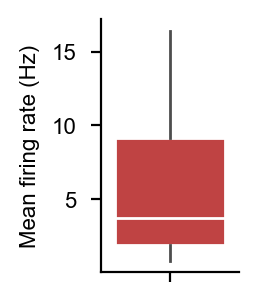

In [ ]:
fig = plt.figure(figsize=set_size('thesis', fraction=.15, subplots=(3, 1)))
# define gca of figure
# axs = axs.ravel()
# fig.subplots_adjust(hspace = 1, wspace= 2)

# plot seaborn boxplot and pointplot to show 

sns.boxplot(
    data=label_df.query('shuff_pass == 1'),
    x="constant",
    y="mean_rate",
    linewidth=1,
    fliersize=0,
    showfliers=False,
    medianprops=dict(color="white", alpha=1),
    capprops=dict(alpha=0),
    boxprops=dict(edgecolor="white"),
    color="#D32F2F",
)

# sns.stripplot(
#     data=label_df.query('shuff_pass == 1'),
#     x="constant",
#     y="mean_rate",
#     linewidth=1,
#     s=1,
#     color="black",
# )

# plt.yscale('log')
plt.ylabel('Mean firing rate (Hz)')
plt.xlabel('')
plt.xticks([0],[''])
sns.despine(fig = fig, left=False, bottom=False)
plt.savefig(r'Y:\laura_berkowitz\VR_ephys\figures\place_cell_fr.svg',dpi=300,bbox_inches='tight')

### Information content of place cells

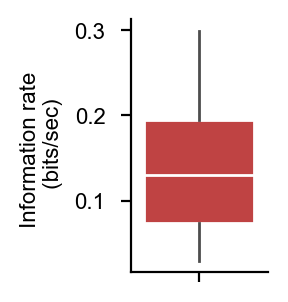

In [ ]:
# plot specifity and IC for each cell color coded by those that are place cells and those that are not

fig = plt.figure(figsize=set_size('thesis', fraction=.15, subplots=(3, 1)))
# define gca of figure
# axs = axs.ravel()
# fig.subplots_adjust(hspace = 1, wspace= 2)

# plot seaborn boxplot and pointplot to show 

sns.boxplot(
    data=label_df.query('shuff_pass == 1'),
    x="constant",
    y="info_rate",
    linewidth=1,
    fliersize=0,
    showfliers=False,
    medianprops=dict(color="white", alpha=1),
    capprops=dict(alpha=0),
    boxprops=dict(edgecolor="white"),
    color="#D32F2F",
)

# sns.stripplot(
#     data=label_df.query('shuff_pass == 1'),
#     x="constant",
#     y="info_rate",
#     linewidth=1,
#     s=1,
#     color="black",
# )

# plt.yscale('log')
plt.ylabel('Information rate \n (bits/sec)')
plt.xlabel('')
plt.xticks([0],[''])
sns.despine(fig = fig, left=False, bottom=False)
plt.savefig(r'Y:\laura_berkowitz\VR_ephys\figures\place_cell_info_rate.svg',dpi=300,bbox_inches='tight')

### Proportion of recorded cells that met critera as place cells

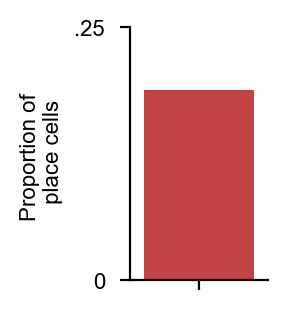

In [ ]:
# for second axis, show proportion of cells that are place cells without error bar
# plot specifity and IC for each cell color coded by those that are place cells and those that are not

fig = plt.figure(figsize=set_size('thesis', fraction=.15, subplots=(3, 1)))

sns.barplot(
    data=label_df,
    x="constant",
    y="shuff_pass",
    linewidth=1,
    errorbar=None,
    color="#D32F2F",
)

plt.ylim([0,.25])
plt.ylabel('Proportion of \n place cells')
plt.yticks([0,.25],['0','.25'])
plt.xlabel('')
plt.xticks([0],[''])
# remove spines 
sns.despine(fig = fig, left=False, bottom=False)



plt.savefig(r'Y:\laura_berkowitz\VR_ephys\figures\proportion_place_cells.svg',dpi=300,bbox_inches='tight')



### print proportions

In [ ]:
label_df.shuff_pass.value_counts()/label_df.shape[0]

False    0.811881
True     0.188119
Name: shuff_pass, dtype: float64

## print n cells

In [ ]:
label_df.shuff_pass.value_counts()

False    246
True      57
Name: shuff_pass, dtype: int64

### create markdown table of cells per session

In [ ]:
# make a pivot table showing the number of cells that passed shuffle across each session
label_df.pivot_table(index="basepath", values="shuff_pass", aggfunc="sum")
# convert pivot table to latex table
print(label_df.pivot_table(index="basepath", values="shuff_pass", aggfunc="sum").to_markdown())

| basepath                                                       |   shuff_pass |
|:---------------------------------------------------------------|-------------:|
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day08_230413_095156 |           15 |
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day09_230414_154029 |            9 |
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day10_230417_133959 |           10 |
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day11_230420_114016 |            1 |
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day12_230421_133630 |            8 |
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day13_230424_104512 |            3 |
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day14_230425_121247 |            7 |
| Y:\laura_berkowitz\VR_ephys\data\VR05\VR05_day13_230424_104512 |            4 |
| Y:\laura_berkowitz\VR_ephys\data\VR05\VR05_day18_230501_091912 |            0 |


### do the same with 'count' to get n CA1 cells recorded in session. Note shuff_pass column header should be 'n_cells' when using count function

In [ ]:
print(label_df.pivot_table(index="basepath", values="shuff_pass", aggfunc="count").to_markdown())

| basepath                                                       |   shuff_pass |
|:---------------------------------------------------------------|-------------:|
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day08_230413_095156 |           35 |
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day09_230414_154029 |           31 |
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day10_230417_133959 |           29 |
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day11_230420_114016 |           27 |
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day12_230421_133630 |           30 |
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day13_230424_104512 |           29 |
| Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day14_230425_121247 |           26 |
| Y:\laura_berkowitz\VR_ephys\data\VR05\VR05_day13_230424_104512 |           45 |
| Y:\laura_berkowitz\VR_ephys\data\VR05\VR05_day18_230501_091912 |           51 |


### Get the summary statistics for place cells information content

In [ ]:
label_df.query('shuff_pass == 1').info_rate.describe()


count    57.000000
mean      0.205399
std       0.307296
min       0.029682
25%       0.074337
50%       0.129686
75%       0.194211
max       2.069193
Name: info_rate, dtype: float64

### Testing below

In [ ]:
# example session
r'Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day08_230413_095156'

'Y:\\laura_berkowitz\\VR_ephys\\data\\VR04\\VR04_day08_230413_095156'

In [ ]:
basepath = r'Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day08_230413_095156'

# load position
position_df = loading.load_animal_behavior(basepath)

# restrict to non-nan times
position_df_no_nan = position_df.query("not x.isnull() & not y.isnull()")
position_df_no_nan['x'] = position_df_no_nan['x'] + np.abs(position_df_no_nan['x'].min())
pos = nel.AnalogSignalArray(
    data=position_df_no_nan["x"].values.T,
    timestamps=position_df_no_nan.timestamps.values,
)

# load in spike data from hpc pyramidal cells
st,cm = loading.load_spikes(basepath,putativeCellType="Pyr|Int",brainRegion="CA1|Dentate") #,brainRegion="CA1"


### load in behavior epochs for basepath

here, I'm interested in the vr_linear_track epoch

In [ ]:
epoch_df = loading.load_epoch(basepath)

beh_epochs = nel.EpochArray(np.array([epoch_df.startTime,epoch_df.stopTime]).T)
# you can change this based on which session you want to look at
behavior_idx = int(epoch_df[epoch_df.name.str.contains('vr')].index[0])
print(behavior_idx)
epoch_df

1


,name,startTime,stopTime,environment,basepath
0,pre_task_sleep,5.495433,7876.490733,sleep,Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day...
1,vr_linear_track,7879.176200,9474.187367,linear_track,Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day...
2,post_task_sleep1,9706.794633,18323.816367,sleep,Y:\laura_berkowitz\VR_ephys\data\VR04\VR04_day...


### Make 1d maps using neuropy maps class

### Construct the postion array with linearized coords

note, you can see if you print out nelpy arrays, there is very helpful information

### Retrieve position in epoch 

In [ ]:
# use epoch arrays to restrict position and spike times to the behavior epoch
pos = pos[beh_epochs[behavior_idx]]
pos

<AnalogSignalArray at 0x1e302821c10: 1 signals (60 segments)> for a total of 17:29:147 minutes

### Plot the position

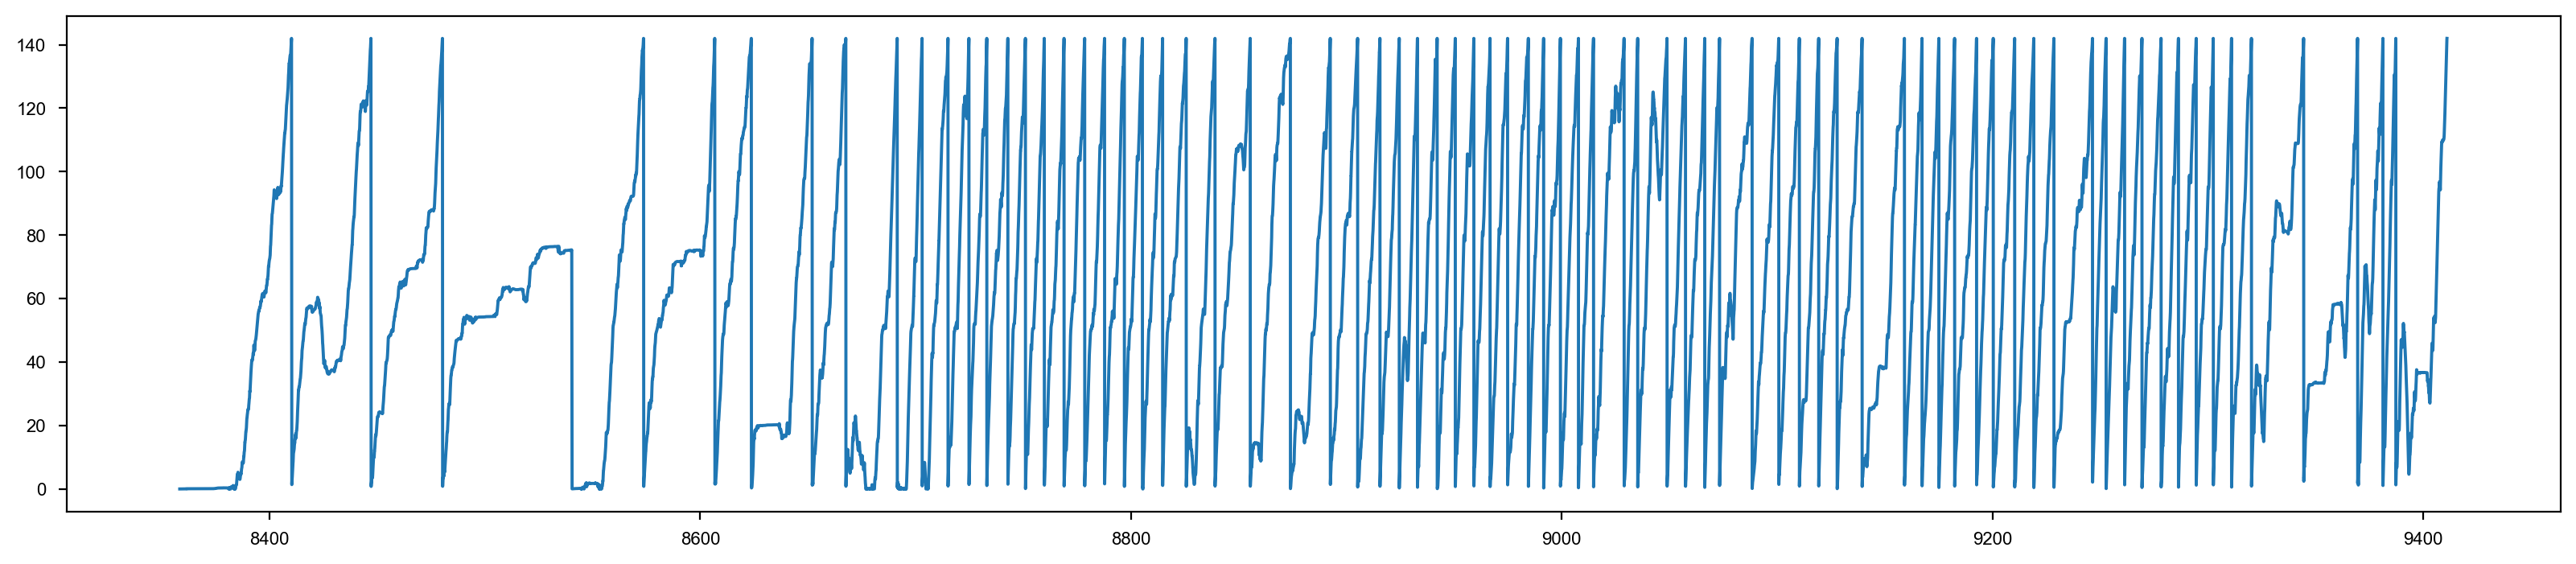

In [ ]:
#plot position with run epoch applied
plt.figure(figsize=(20,4))
plt.plot(pos[beh_epochs[behavior_idx]].abscissa_vals,pos[beh_epochs[behavior_idx]].data.T)

### Get outbound and inbound epochs

In [ ]:
# get outbound and inbound epochs
(outbound_epochs, inbound_epochs) = get_linear_track_lap_epochs(
    pos.abscissa_vals, pos.data[0], newLapThreshold=20
)
outbound_epochs, inbound_epochs

c:\users\schafferlab\documents\ripple_heterogeneity\ripple_heterogeneity\utils\functions.py:993: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(<EpochArray at 0x1e33b3b10d0: 77 epochs> of length 16:13:361 minutes,
 <EpochArray at 0x1e33b3b11f0: 76 epochs> of length 1:19:476 minutes)

### Plot inbound and outbound epochs

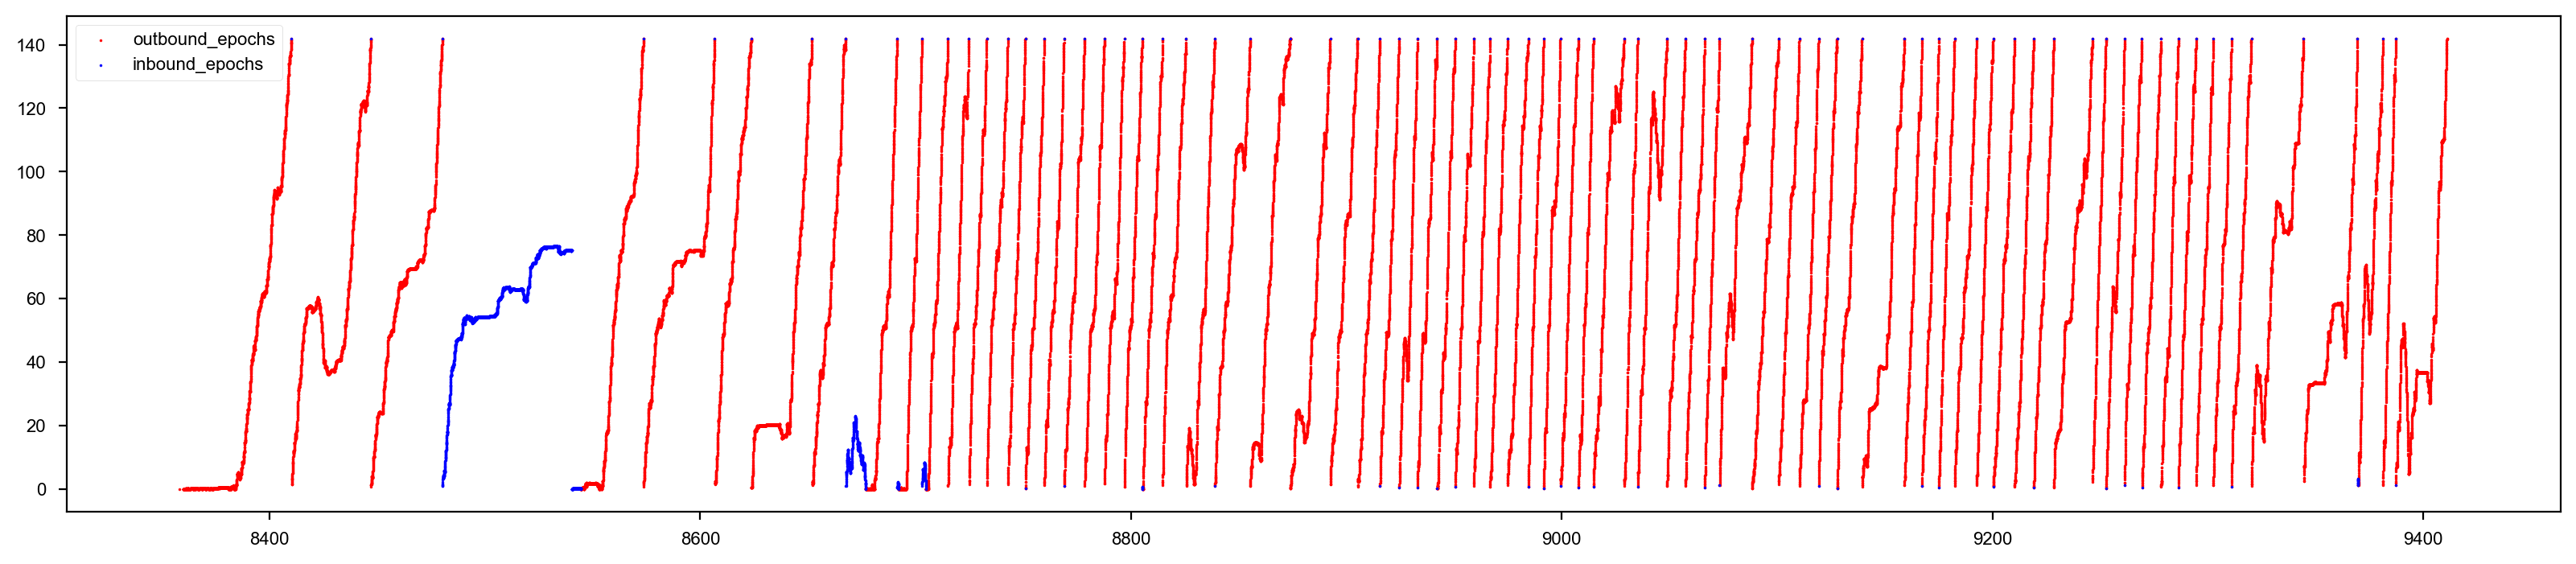

In [ ]:
plt.figure(figsize=(20,4))
plt.scatter(pos[outbound_epochs].abscissa_vals, pos[outbound_epochs].data,color='r',s=1,label='outbound_epochs')
plt.scatter(pos[inbound_epochs].abscissa_vals, pos[inbound_epochs].data,color='b',s=1,label='inbound_epochs')
plt.legend()

### 4.3 Now lets make tuning curves for the outbound trajectories

In [ ]:
spatial_maps = maps.SpatialMap(
    pos[beh_epochs[behavior_idx]],
    st[beh_epochs[behavior_idx]],
    dir_epoch=outbound_epochs,
    dim=1,
    place_field_min_size=5,
    tuning_curve_sigma=3,
    place_field_sigma=.1,
    smooth_mode="wrap",
    speed_thres=10,
    
)
spatial_maps.find_fields()

### plot the run epochs during behavior

for VR linear track, speed threshold is 10cm/s - faster than realworld as the mice run faster in VR ball

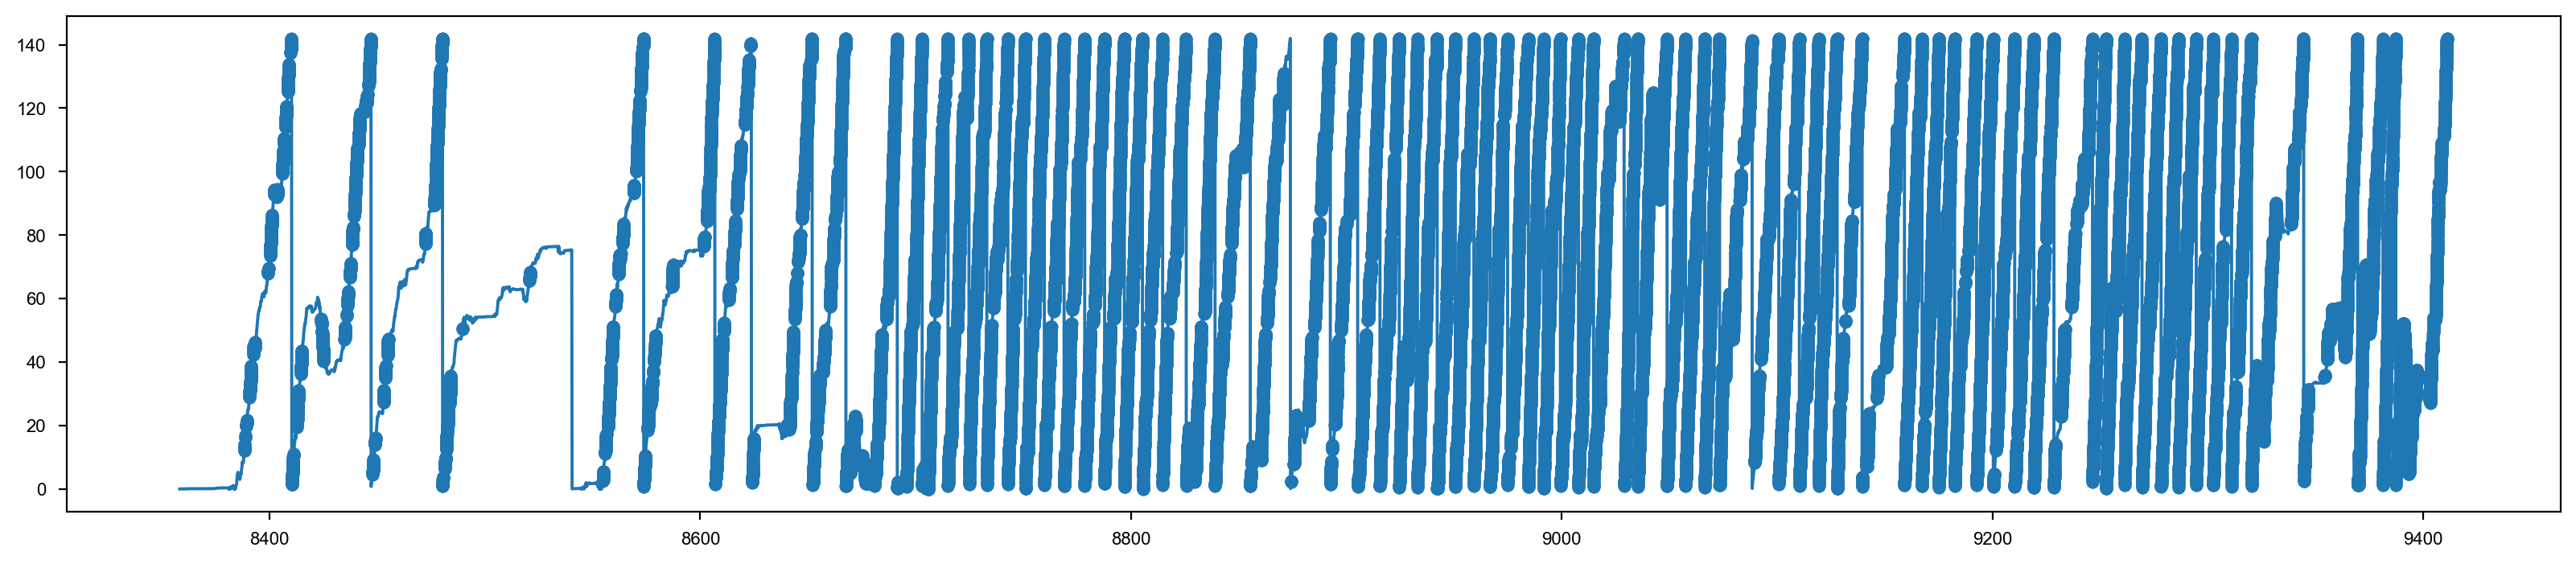

In [ ]:
#plot position with run epoch applied
plt.figure(figsize=(20,4))
plt.plot(pos[beh_epochs[behavior_idx]].abscissa_vals,pos[beh_epochs[behavior_idx]].data.T)
plt.scatter(pos[beh_epochs[behavior_idx]][spatial_maps.run_epochs].abscissa_vals,pos[beh_epochs[behavior_idx]][spatial_maps.run_epochs].data.T)

### for all the 1d ratemaps, compute the pval of IC relative to the shuffled distribution 

In [ ]:
pvals = spatial_maps.shuffle_spatial_information()
pvals

array([0.23952096, 0.08383234, 0.00199601, 0.17365269, 0.00199601,
       0.21756487, 0.04790419, 0.1497006 , 0.31736527, 0.00199601,
       0.00199601, 0.06986028, 0.00199601, 0.10778443, 0.00199601,
       0.24550898, 0.43113772, 0.11377246, 0.00399202, 0.08183633,
       0.00399202, 0.00199601, 0.77045908, 0.00199601, 0.8502994 ,
       0.00598802, 0.77245509, 0.00199601, 0.23952096, 0.00199601,
       0.00199601, 0.84630739, 0.00199601, 0.19760479, 0.77045908])

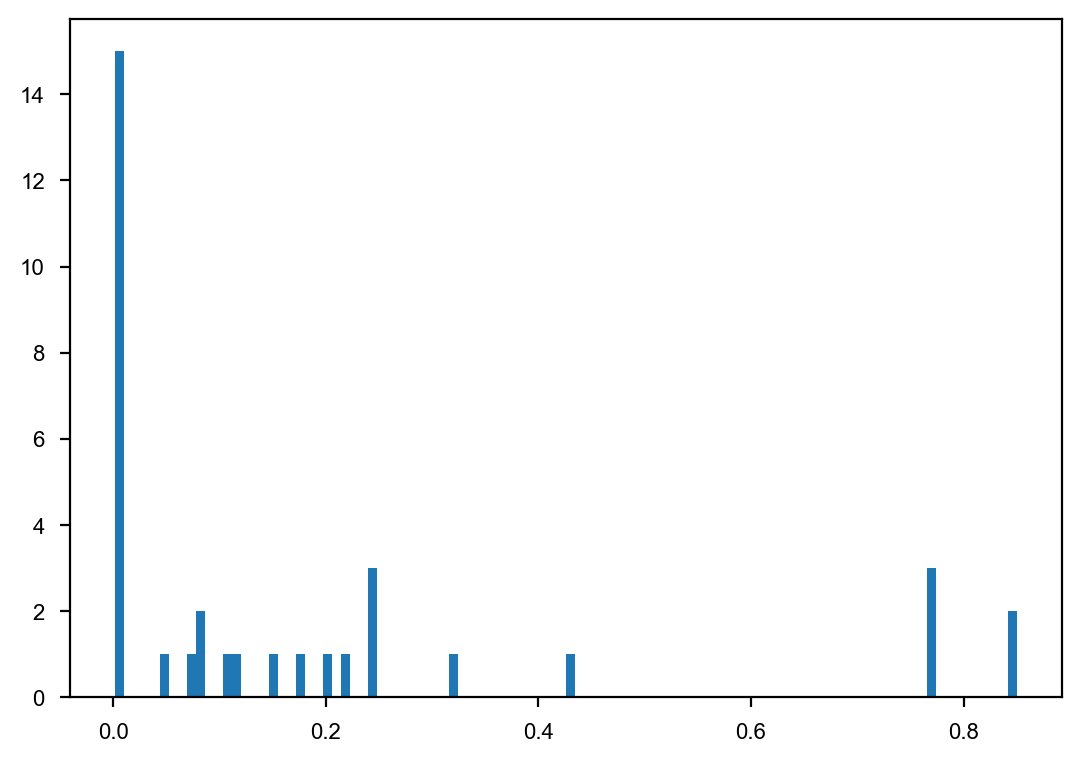

In [ ]:
plt.hist(pvals,bins=100)
plt.show()

### Show spike on path for example cells

4


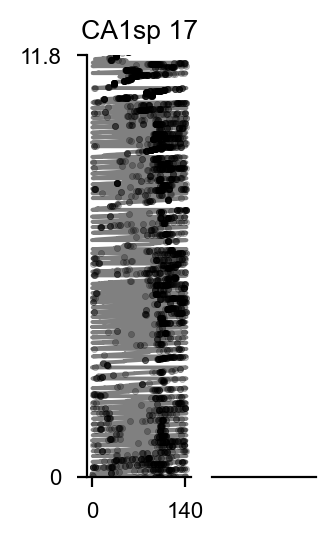

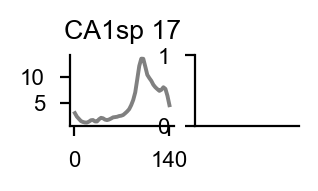

In [ ]:
fig,axs = plt.subplots(1,2, figsize=set_size('thesis',fraction=0.25,subplots=(3,1)))
axs = axs.ravel()

# get position at spikes

# for each cell, plot the position at spikes
for ax, i in enumerate([4]):
    print(i)
    x_time,pos_at_spikes = pos.asarray(at=st[beh_epochs[behavior_idx]].data[i])
    axs[ax].plot(pos.data[0].T,pos.abscissa_vals,color='grey',label='position')
    axs[ax].scatter(pos_at_spikes[0],x_time,color = 'k',alpha = 0.25,label='spikes',zorder=10,s=5)
    axs[ax].set_title(f"{cm.iloc[i].brainRegion} {cm.iloc[i].UID}")
    axs[ax].set_ylim([8690,9400])

# only keep ytick labels for top and bottom 
axs[0].set_yticks([8690,9400],[0,11.8])
axs[0].set_xticks([0,140],[0,140])
# remove yticks for second axis 
axs[1].set_yticks([])
axs[1].set_xticks([])


# remove spines
sns.despine(ax=axs[0], left=False, bottom=False)
sns.despine(ax=axs[1], left=True, bottom=False)

plt.savefig(r'Y:\laura_berkowitz\VR_ephys\figures\example_spike_on_path.svg',dpi=300,bbox_inches='tight')



fig,axs = plt.subplots(1,2, figsize=set_size('thesis',fraction=0.25,subplots=(1,2)))
axs = axs.ravel()

# for each cell, plot the position at spikes
for ax, i in enumerate([4]):
    x_time,pos_at_spikes = pos.asarray(at=st[beh_epochs[behavior_idx]].data[i])
    axs[ax].plot(spatial_maps.bin_centers,spatial_maps.ratemap[i],color='grey',label='position')
    axs[ax].set_title(f"{cm.iloc[i].brainRegion} {cm.iloc[i].UID}")

# only keep ytick labels for top and bottom 
axs[0].set_xticks([0,140],[0,140])
# remove yticks for second axis 
axs[1].set_xticks([])


# remove spines
sns.despine(ax=axs[0], left=False, bottom=False)
sns.despine(ax=axs[1], left=False, bottom=False)

plt.savefig(r'Y:\laura_berkowitz\VR_ephys\figures\overall_tuning.svg',dpi=300,bbox_inches='tight')


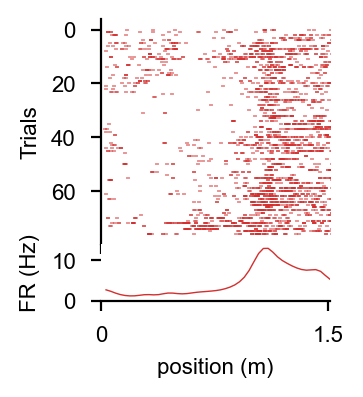

In [ ]:
# from neuro_py.plotting.events import plot_peth
unit_index = 4

spk_pos = []
for ep_i, ep in enumerate(outbound_epochs):
    spk_pos.append(
        np.interp(
            st[ep[spatial_maps.run_epochs]].data[unit_index],
            pos[ep[spatial_maps.run_epochs]].abscissa_vals,
            pos[ep[spatial_maps.run_epochs]].data[0],
        )
    )

fig, axs = plt.subplots(
    2,
    1,
    figsize=set_size("thesis", fraction=0.25, subplots=(2, 1)),
    gridspec_kw={"height_ratios": [4, 1]},
    sharex=True,
    )
axs = axs.ravel()
plt.subplots_adjust(hspace=0)

spatial_offset = np.abs(spatial_maps.bin_centers.min())
x = spatial_maps.bin_centers + spatial_offset
axs[1].plot(x,spatial_maps.smooth(sigma=3).ratemap[unit_index],alpha=1,linewidth=.5,color="#D32F2F")
# sns.lineplot(x=x, y=spatial_maps.smooth(sigma=10).ratemap[unit_index], ax=axs[0],errorbar=('ci', 95))

# axs[1].fill_between(x,spatial_maps.smooth(sigma=3).ratemap[unit_index],alpha=.5,color="#D32F2F")
axs[1].set_ylabel('FR (Hz)')
axs[1].set_xlim([0,x.max()])
axs[1].set_ylim([0,spatial_maps.smooth(sigma=3).ratemap[unit_index].max()+1])
# initialize laps 
laps = []
for ep_i, ep in enumerate(outbound_epochs):
    axs[0].scatter(spk_pos[ep_i]+spatial_offset,np.ones_like(spk_pos[ep_i])*ep_i,alpha=.5,s=.15,marker="|",color="#D32F2F")
    # bin spikes by position 
    # axs[1].histogram(spk_pos[ep_i],bins=spatial_maps.bin_edges)
    y, _ = np.histogram(spk_pos[ep_i],bins=spatial_maps.bin_centers + spatial_offset)
    laps.append(y)

# convert laps to array
laps = np.array(laps)

# calculate mean and sem of laps
# sns.lineplot(x=x, y=spatial_maps.smooth(sigma=10).ratemap[unit_index], ax=axs[0],errorbar=('ci', 95))

# axs[0].set_xticks([])
axs[0].set_xticks([0,141],[0,1.5])
axs[1].set_xlabel('position (m)')
axs[0].set_ylabel('Trials')
axs[0].invert_yaxis()

sns.despine(ax=axs[0],bottom=True)
sns.despine(ax=axs[1], left=True, bottom=False)

# save figure 
plt.savefig(r'Y:\laura_berkowitz\VR_ephys\figures\example_place_cell_4.svg',dpi=300,bbox_inches='tight')

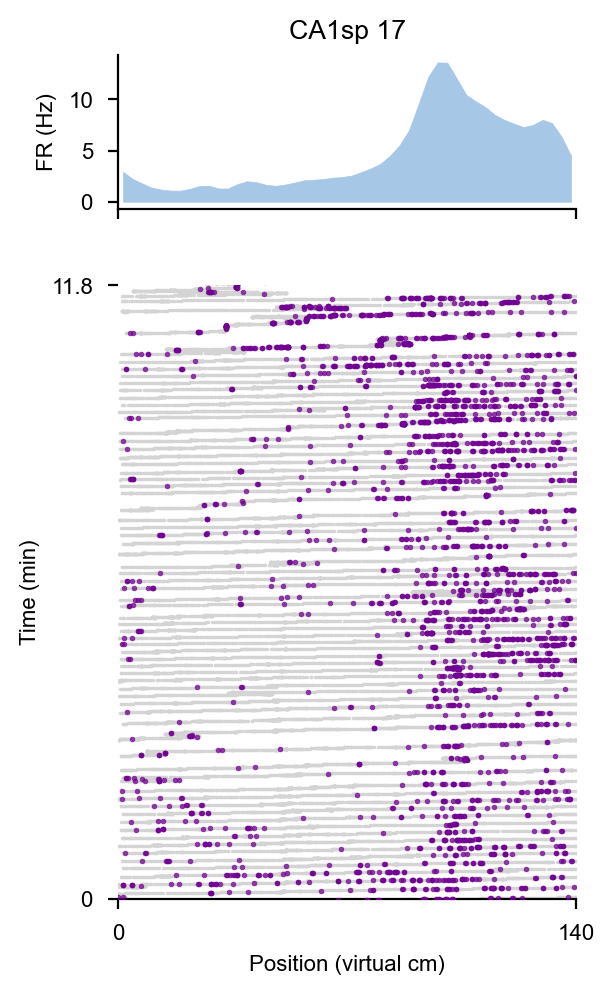

In [ ]:
fig, axs = plt.subplots(
    2,
    1,
    figsize=set_size("thesis", fraction=0.5, subplots=(3, 1)),
    gridspec_kw={"height_ratios": [1, 4]},
    sharex=True,
)
axs = axs.ravel()

# get position at spikes
cell = 4
# npl.plot_tuning_curves1D(spatial_maps.ratemap[cell], normalize=True, pad=1)
axs[0].fill_between(
    spatial_maps.bin_centers,
    spatial_maps.ratemap[cell],
    color="#A7C7E7",
    label="position",
)
axs[0].set_title(f"{cm.iloc[cell].brainRegion} {cm.iloc[cell].UID}")
axs[0].set_ylabel("FR (Hz)")

# for each cell, plot the position at spikes
x_time, pos_at_spikes = pos.asarray(at=st[beh_epochs[behavior_idx]].data[cell])
axs[1].scatter(pos.data[0].T, pos.abscissa_vals, color="#D4D4D4", label="position", s=1)
axs[1].scatter(
    pos_at_spikes[0], x_time, color="#710193", alpha=0.75, label="spikes", zorder=10, s=3
)
axs[1].set_ylim([8690, 9400])

# only keep ytick labels for top and bottom
axs[1].set_yticks([8690, 9400], [0, 11.8])
axs[1].set_xticks([pos.min(), pos.max()], [0, 140])
axs[1].set_xlabel("Position (virtual cm)")
axs[1].set_ylabel("Time (min)")
axs[1].set_xlim([pos.min(), pos.max()])

# remove spines
sns.despine(ax=axs[0], left=False, bottom=False)
sns.despine(ax=axs[1], left=True, bottom=False)

plt.savefig(r'Y:\laura_berkowitz\VR_ephys\figures\example_place_cell.svg',dpi=300,bbox_inches='tight')


# plt.savefig(r'Y:\laura_berkowitz\VR_ephys\figures\overall_tuning.svg',dpi=300,bbox_inches='tight')

### Restrict to place cells

and plot all for this session

In [ ]:
tc = spatial_maps.tc
st_run = st[beh_epochs[behavior_idx]][spatial_maps.run_epochs]
bst_run = st_run.bin(ds=.200)

### plot all cells

In [ ]:
from ripple_heterogeneity.replay import replay_run 

# construct tuning curves
ds_50ms = 0.05
s_binsize = 5
tuning_curve_sigma = 3
speed_thres = 10
place_cell_min_spks=100
place_cell_peak_mean_ratio=1.5
place_cell_min_rate=1
ds_beh_decode = .2

tc, st_run, bst_run, run_epochs = replay_run.get_tuning_curves(
    pos, st, outbound_epochs, speed_thres, ds_50ms, s_binsize, tuning_curve_sigma
)

(
    sta_placecells,
    tc,
    bst_run,
    cell_metrics_,
    total_units,
) = replay_run.restrict_to_place_cells(
    tc,
    st_run,
    bst_run,
    st,
    cm,
    place_cell_min_spks,
    place_cell_min_rate,
    place_cell_peak_mean_ratio,
)
bst_run_beh = sta_placecells[outbound_epochs].bin(ds=ds_beh_decode)


### Nelpy has a pretty plot for this purpose

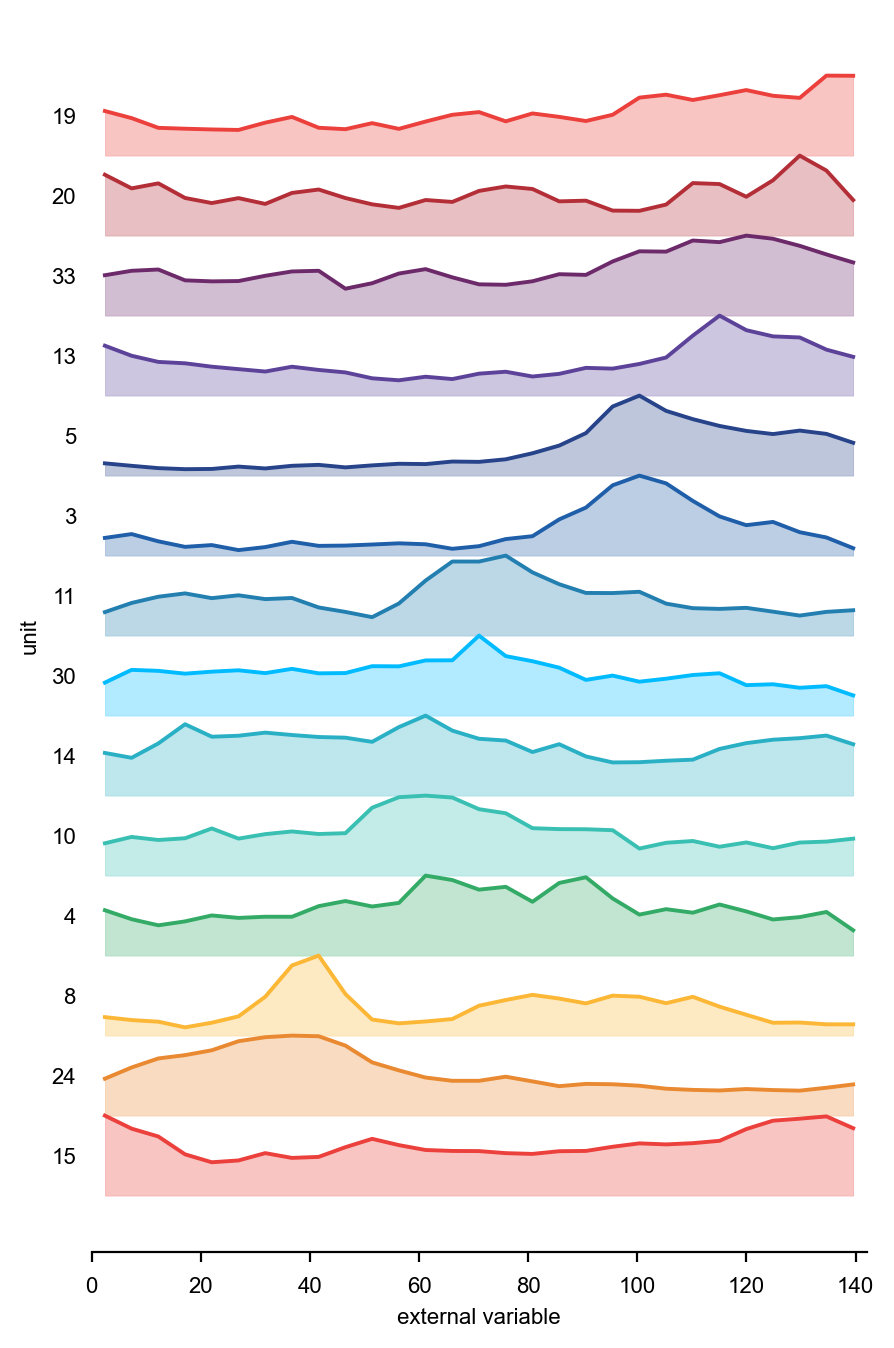

In [ ]:
tc_reordered = tc.reorder_units()
npl.set_palette(npl.colors.rainbow)
with npl.FigureManager(show=True, figsize=(5, 8)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.plot_tuning_curves1D(tc_reordered, normalize=True, pad=1)